# Part I - Ford Go Bike Exploratory Analysis
#### Garrett Peters

## Introduction

The Ford GoBike dataset contains information about individual bike rides in the Ford GoBike bike-sharing system, which operates across the greater San Francisco Bay Area. This system allows users to rent bicycles from designated docking stations throughout the region. The dataset includes data for 183,412 bike rentals that occurred during the month of February. It provides key attributes about each ride, such as trip details (e.g., duration, start and end locations, and times), day-related information (including the date and time of each trip), and customer data, which reveals whether the rider is a subscriber or a casual user. This data offers valuable insights into bike usage patterns and trends within the San Francisco Bay Area, which can be used for further analysis of bike-sharing behavior.

## Preliminary Wrangling

Here we will load in the data set, look at the first few lines, the shape, the variables and their types


In [31]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
# Load the CSV into a DataFrame
GoBike = pd.read_csv('201902-fordgobike-tripdata.csv')

# How many entries and variables
print(GoBike.shape)
# variables and their data type
print(GoBike.dtypes)
# View the first few lines
GoBike.head()

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


Printing shape, data type and using the head function to see first 5 entries

## Preliminary Cleaning

There are several variables in the dataset that are difficult to interpret and could benefit from cleaning to enhance readability. By cleaning these variables, we can improve the overall understanding and usability of the data.

In [33]:
# Rename and convert 'duration_sec' to minutes
GoBike['duration_sec'] = GoBike['duration_sec'] / 60
GoBike.rename(columns={'duration_sec': 'duration_min'}, inplace=True)

Durartion in seconds can be confusing to truly understand how long the rental was, here we changed it to minutes in order improve readability.

In [34]:
## Create a distance variable in miles
# Function to calculate the distance in miles using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Radius of the Earth in miles
    R = 3959
    distance = R * c
    
    return distance

# Create a new 'distance_miles' column in the GoBike dataset
GoBike['distance_miles'] = GoBike.apply(
    lambda row: haversine(row['start_station_latitude'], row['start_station_longitude'],
                         row['end_station_latitude'], row['end_station_longitude']),
    axis=1
)


Since we have the longitude and latitude for both the start and end stations, we can estimate the distance the renter rode the bike. However, it’s important to note that this distance may not be exact, as there’s a possibility that a renter could start and end their ride at the same station. This estimate can be useful for analyzing general ride patterns, such as average ride distances or popular routes. However, it shouldn’t be used to calculate precise travel distances or for purposes that require high accuracy.

In [35]:
# Ensure 'start_time' is in datetime format
GoBike['start_time'] = pd.to_datetime(GoBike['start_time'])

# Create a 'time_of_day' variable by extracting the hour and categorizing it
def time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the 'start_time' to create the 'time_of_day' column
GoBike['period_of_day'] = GoBike['start_time'].dt.hour.apply(time_of_day)

# Create a readable start time to the 30th minute
def round_to_nearest_30min(time):
    # Calculate the nearest multiple of 30 for minutes
    rounded_start = round(time.minute / 30) * 30
    if rounded_start == 60:
        # If rounding gives 60, reset to 0 and increment the hour
        rounded_start = 0
        time += pd.Timedelta(hours=1)
    # Replace the minute and reset second/microsecond to 0, then format to just 'HH:MM'
    rounded_time = time.replace(minute=rounded_start, second=0, microsecond=0)
    return rounded_time.strftime('%H:%M')  # Format to just 'HH:MM'

# Apply the function to round the 'start_time' to 30-minute increments
GoBike['rounded_time'] = GoBike['start_time'].apply(round_to_nearest_30min)


Here we created two variables to better understand when renters use GoBikes. The first is a categorical variable that groups the time of day into four periods: morning, afternoon, evening, and night. This can be useful for analyzing trends in bike usage throughout the day, allowing us to identify peak times for each period. The second variable is a quantitative time variable, which represents the time rounded to the nearest 20th minute. This can help identify specific busy times of the day when people are renting bikes, providing insight into patterns and helping to optimize bike availability or station placement.

In [36]:
GoBike['start_time'] = pd.to_datetime(GoBike['start_time'])

# Create a new column 'day' with only the date (year-month-day)
GoBike['day_of_week'] = GoBike['start_time'].dt.day_name()

In [37]:
# Calculate age based on the year 2024
GoBike['member_age'] = 2019 - GoBike['member_birth_year']


Since we have the birth year of each customer, we use 2019 to calculate an approximate age. We chose 2019 as the base year based on the information available in the `start_time` and `end_time` columns, which indicate that the data spans for February of that year. This is an approximate age because we are only provided with the birth year, not the specific birth month, meaning the actual age could be slightly different depending on the customer's birthdate.

In [38]:
GoBike.head()

,duration_min,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,distance_miles,period_of_day,rounded_time,day_of_week,member_age
0,869.750000,2019-02-28 17:32:10.145,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,...,4902,Customer,1984.0,Male,No,0.338487,Evening,17:30,Thursday,35.0
1,708.683333,2019-02-28 18:53:21.789,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,...,2535,Customer,NaN,NaN,No,1.083116,Evening,19:00,Thursday,NaN
2,1030.900000,2019-02-28 12:13:13.218,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,5905,Customer,1972.0,Male,No,1.680630,Afternoon,12:00,Thursday,47.0
3,608.166667,2019-02-28 17:54:26.010,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,...,6638,Subscriber,1989.0,Other,No,0.162025,Evening,18:00,Thursday,30.0
4,26.416667,2019-02-28 23:54:18.549,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,...,4898,Subscriber,1974.0,Male,Yes,1.497163,Night,00:00,Thursday,45.0


Here I verify that all of these new variables are added and clean by using the head function. 

## Removing Inaccurate Variables and Values
Subset data to ensure accurate daily activitiy usage of bikes and remove "dirty" variables to ensure the entire dataframe is cleaned

In [39]:
# Remove dirty columns
GoBike_cleaned = GoBike.drop(columns=[
    'start_time', 'end_time', 'start_station_id', 'start_station_name', 
    'start_station_latitude', 'start_station_longitude', 'end_station_id', 
    'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', "member_birth_year"
])

# Drop Missing Values
GoBike_cleaned = GoBike_cleaned.dropna()

# Check the updated dataframe

# How many entries and variables
print(GoBike_cleaned.shape)
# variables and their data type
print(GoBike_cleaned.dtypes)
# View the first few lines
GoBike_cleaned.head()

(175147, 9)
duration_min               float64
user_type                   object
member_gender               object
bike_share_for_all_trip     object
distance_miles             float64
period_of_day               object
rounded_time                object
day_of_week                 object
member_age                 float64
dtype: object


,duration_min,user_type,member_gender,bike_share_for_all_trip,distance_miles,period_of_day,rounded_time,day_of_week,member_age
0,869.750000,Customer,Male,No,0.338487,Evening,17:30,Thursday,35.0
2,1030.900000,Customer,Male,No,1.680630,Afternoon,12:00,Thursday,47.0
3,608.166667,Subscriber,Other,No,0.162025,Evening,18:00,Thursday,30.0
4,26.416667,Subscriber,Male,Yes,1.497163,Night,00:00,Thursday,45.0
5,29.883333,Subscriber,Male,No,2.070662,Night,00:00,Thursday,60.0


Deleting unnecessary variables from a dataframe can help streamline your data analysis and improve the performance of your code. By removing columns that are irrelevant to your analysis, you reduce the size of the dataframe, which can speed up computations and reduce memory usage. This is especially important when working with large datasets, as unnecessary variables can slow down operations and make the dataset harder to manage. Additionally, focusing only on the relevant variables ensures that your analysis is more straightforward and reduces the risk of confusion or errors caused by irrelevant data. It also helps with visualization and interpretation, making the dataset more concise and easier to understand. I also dropped any entry that contained any missing value

### What is the structure of your dataset?

- **Number of Rows**: 175,147
- **Number of Columns**: 9

### Columns:
1. **duration_min**: Numeric variable representing the duration of the bike trip in minutes.
2. **user_type**: Categorical variable indicating whether the user is a member or a non-member.
3. **member_gender**: Categorical variable indicating the gender of the bike rider (e.g., male, female, or unknown).
4. **bike_share_for_all_trip**: Categorical variable indicating whether the trip was part of a bike share program available to all users (yes/no).
5. **distance_miles**: Numeric variable representing the distance traveled during the bike trip in miles.
6. **period_of_day**: Categorical variable grouping the time of day into periods (morning, afternoon, evening, night).
7. **rounded_time**: Numeric variable representing the time of day rounded to the nearest 20th minute.
8. **member_age**: Numeric variable representing the approximate age of the rider, based on their birth year and the base year of 2019.
9. **day_of_week**: Categorical variable representing the day the bike was rented

### Summary:
The dataset contains **175,147 values**, with each row representing a bike trip. The columns provide insights into the duration, user type, gender, distance, time of day, and approximate age of the rider, as well as whether the trip was part of a universal bike share program.


### What is/are the main feature(s) of interest in your dataset?

The main feature of interst in the dataset is going to be the duration of rideshare. It will be interesting to see which variables better predict longer rides. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I hypothesize that longer distances, younger ages, and mornings will correlate with longer ride durations. Additionally, it will be interesting to explore if gender plays a role in predicting trip duration.

## Univariate Exploration

### Count plot: Gender

**Lets answer the question: What are the gender counts of the renters**

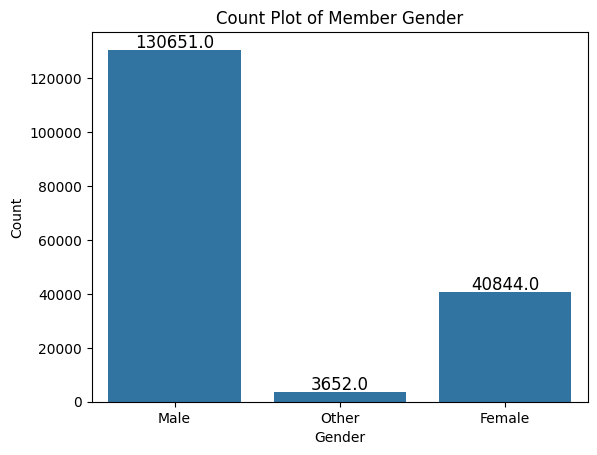

In [40]:
ax = sns.countplot(x='member_gender', data=GoBike_cleaned)

# Add frequency labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),  # Adjust position to avoid overlapping with bars
                textcoords='offset points')

# Add labels and title
plt.title('Count Plot of Member Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()

This plot shows that 130651 entries were male, 40844 entries were female and 3652 entries were unspecified

### Count Plot: Day of week

**Lets answer the question: What day is the busiest?**

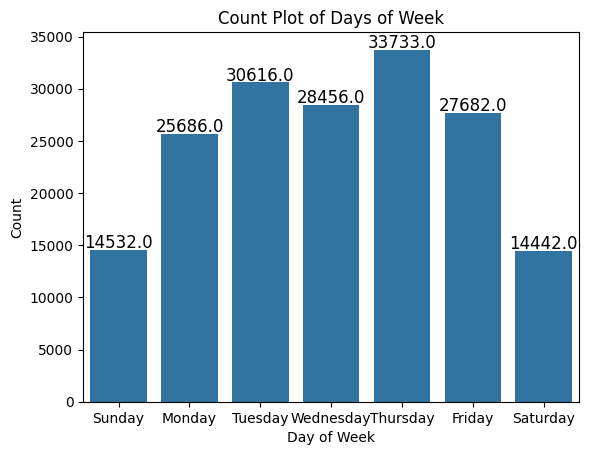

In [41]:
#Create Order for clarity
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Create the count plot with the specified order of days
ax = sns.countplot(x='day_of_week', data=GoBike_cleaned, order=day_order)

# Add frequency labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),  # Adjust position to avoid overlapping with bars
                textcoords='offset points')

# Add labels and title
plt.title('Count Plot of Days of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')

# Show the plot
plt.show()

As shown in the plot above, Sunday and Saturday have the lowest bike rental counts, while Tuesday and Thursday exhibit the highest counts. Monday, Wednesday, and Friday have rental counts that are slightly lower than those of Tuesday and Thursday, but still above the weekend days

### Count Plot: Rounded Time

**Lets answer the question: What time of day is the busiest? During sunlight hours, when is the best time to rent a bike?**

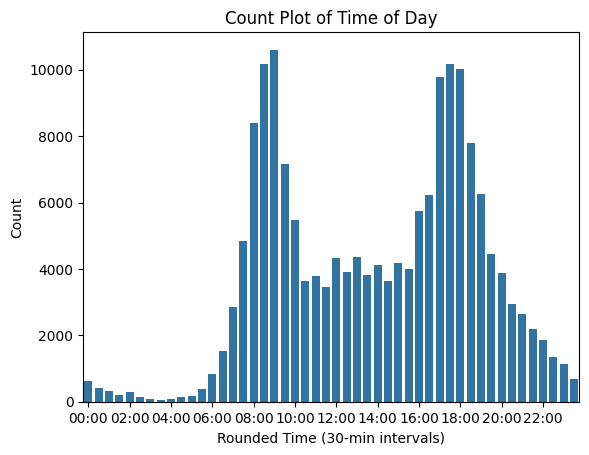

In [42]:
# Create the count plot
ax = sns.countplot(x='rounded_time', data=GoBike_cleaned, order=sorted(GoBike_cleaned['rounded_time'].unique()))

# Get the current x-ticks and labels
ticks = ax.get_xticks()
labels = ax.get_xticklabels()

# Show every fourth to avoid overcrowding
plt.xticks(ticks[::4], labels[::4]) 
# Add labels and title
plt.title('Count Plot of Time of Day')
plt.xlabel('Rounded Time (30-min intervals)')
plt.ylabel('Count')

# Show the plot
plt.show()

The plot above shows a bar for each 30 minute interval of the day and its corresponding frequency of rentals, to answer the question we see that the highest bar on the graph is reprsented for the 9:00AM clock time slot, remember since these are rounded this is anywhere between (approximately) 8:45AM and 9:15AM. If you were looking to rent a bike during daylight the least best time (least busiest) is anywhere between 11:15am and 11:45.

### Histogram and Summary Stats: Duration 

**Looking at the features of interest: What is the mean duration of rental?**

In [43]:
#Look at summary statistics of GoBike
GoBike['duration_min'].describe()

count    183412.000000
mean         12.101307
std          29.906496
min           1.016667
25%           5.416667
50%           8.566667
75%          13.266667
max        1424.066667
Name: duration_min, dtype: float64

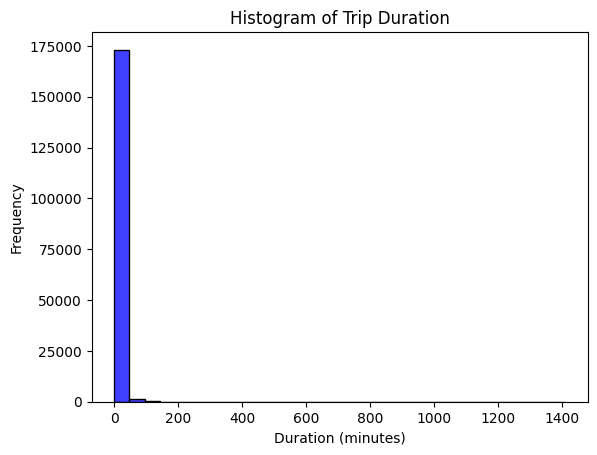

In [44]:
sns.histplot(GoBike_cleaned['duration_min'], bins=30, kde=False, color='blue')

# Add labels and title
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Duration')

# Show plot
plt.show()

Looking at the plot above it is hard to answer this question. We can tell that the majority of the rentals are under 200 minutes, but some rentals go up to 1400. The summary stats state that 75% of the data is under 13.26 minutes. This would mean that there are many outliers and we should subset the data down by removing outliers.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Upon examining the dataset, we observe the presence of extreme outliers in the `duration_min` column, which represent unusually long bike trip durations. These values are atypical for a ride-sharing application and may be indicative of bikes that were left unattended for extended periods before being returned. To ensure our analysis focuses on typical daily GoBike usage, we will remove these extreme outliers by establishing a threshold. This will allow us to analyze data that more accurately reflects the usual patterns of bike activity within the system.

In [45]:
# Identify Q1 and Q3 for age and duration
Q1 = GoBike_cleaned['duration_min'].quantile(0.25)
Q3 = GoBike_cleaned['duration_min'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier thresholds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove outliers
GoBike_cleaned = GoBike_cleaned[(GoBike_cleaned['duration_min'] >= lower_bound) & (GoBike_cleaned['duration_min'] <= upper_bound)]

**Readdressing the question: What is the mean duration of rental?**

In [46]:
# Check the cleaned data
GoBike_cleaned[['duration_min']].describe()

,duration_min
count,165786.000000
mean,9.170639
std,5.071740
min,1.016667
25%,5.233333
50%,8.133333
75%,12.183333
max,24.800000


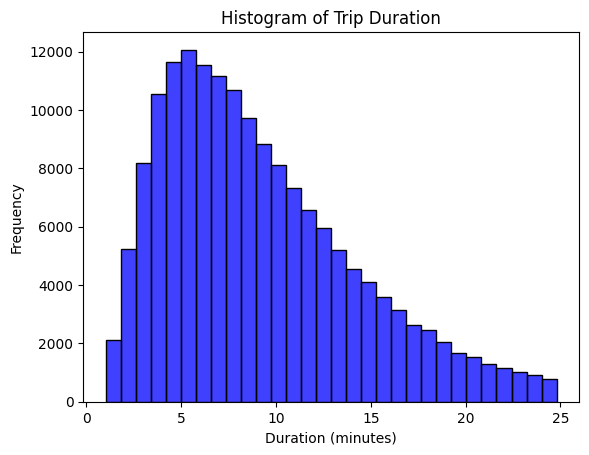

In [47]:
# Creating a new histogram of duration post removal of outliers
sns.histplot(GoBike_cleaned['duration_min'], bins=30, kde=False, color='blue')

# Add labels and title
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Duration')

# Show plot
plt.show()

Now that the outliers are removed we can answer our question and determine that the mean of the duration of rentals is 9.229 minutes.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution was initially heavily right-skewed with significant outliers that distorted the representation of customer experience. After removing these outliers, the distribution still exhibits some right skewness, but it is much more refined and suitable for analysis.

## Bivariate Exploration

### Boxplot: Period of Day vs Distance

**Lets answer the question: What period of the day holds the longer average ride distance?**

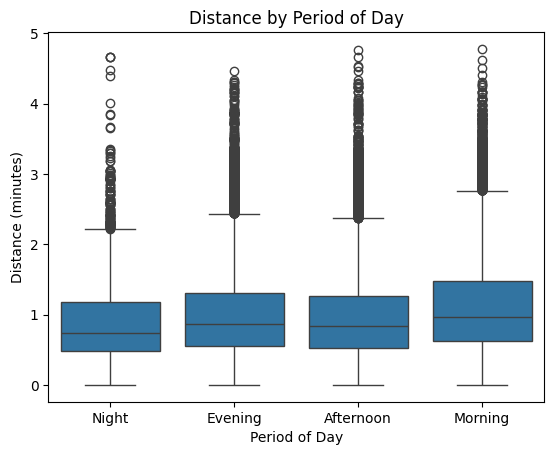

In [48]:
#Boxplot of period of day
sns.boxplot(x='period_of_day', y='distance_miles', data=GoBike_cleaned)
plt.title('Distance by Period of Day')
plt.xlabel('Period of Day')
plt.ylabel('Distance (minutes)')
plt.show()

In [49]:
# Calculate the mean duration for each group
mean_distance_per_period = GoBike_cleaned.groupby('period_of_day')['distance_miles'].mean()

# Display the result
print(mean_distance_per_period)

period_of_day
Afternoon    0.955505
Evening      0.999609
Morning      1.117976
Night        0.893200
Name: distance_miles, dtype: float64


From the plot above we observe that the average rental is the longest in the morning. The renter travels on average 1.12 miles in the morning, 1 mile in the evening, 0.95 miles in the afternoon and 0.89 miles at night

### Boxplot: Period of Day vs Duration of Rental

**Lets answer the question: What period of the day holds the longer average duration of rentals?**

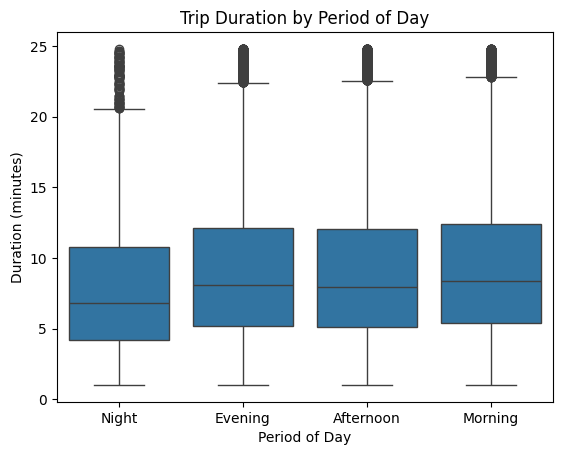

In [50]:
#Boxplot of period of day
sns.boxplot(x='period_of_day', y='duration_min', data=GoBike_cleaned)
plt.title('Trip Duration by Period of Day')
plt.xlabel('Period of Day')
plt.ylabel('Duration (minutes)')
plt.show()

In [51]:
# Calculate the mean duration for each group
mean_duration_per_period = GoBike_cleaned.groupby('period_of_day')['duration_min'].mean()

# Display the result
print(mean_duration_per_period)


period_of_day
Afternoon    9.118822
Evening      9.136458
Morning      9.316633
Night        8.110748
Name: duration_min, dtype: float64


After looking at the plot and their corresponding means we can see that Morning has the highest mean duration. Each group has a similar mean duration, meaning that there is not much difference between period of day. 

### Boxplot: Gender vs Duration of Rental

**Lets answer the question: What gender holds the longer average duration of rentals?**

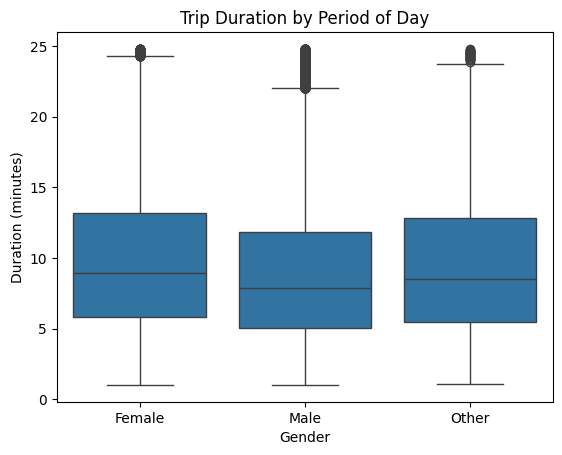

In [52]:
#Boxplot of period of day
sns.boxplot(x='member_gender', y='duration_min', data=GoBike_cleaned)
plt.title('Trip Duration by Period of Day')
plt.xlabel('Gender')
plt.ylabel('Duration (minutes)')
plt.show()

In [53]:
mean_duration_per_gender = GoBike_cleaned.groupby('member_gender')['duration_min'].mean()

# Display the result
print(mean_duration_per_gender)

member_gender
Female    9.905379
Male      8.934852
Other     9.541772
Name: duration_min, dtype: float64


Females have a higher duration in minutes with an average of 9.90 than males with an average of 8.93 and unspecified with an average of 9.54

### Scatterplot: Trip Distance vs Duration of Rental

**Lets answer the question: What is the relationship between distance and duration?**

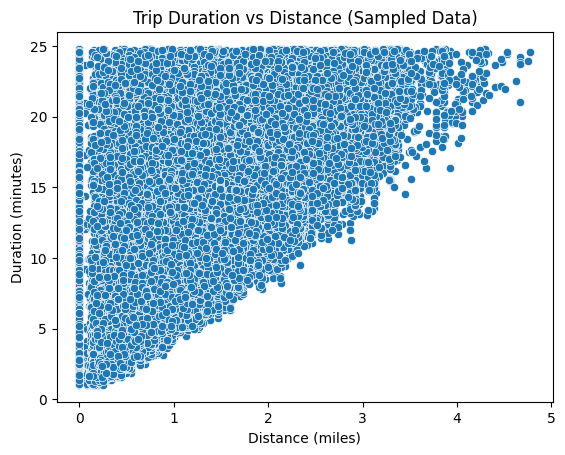

In [54]:
# Randomly sample 10% of the data
sns.scatterplot(x='distance_miles', y='duration_min', data=GoBike_cleaned)
plt.title('Trip Duration vs Distance (Sampled Data)')
plt.xlabel('Distance (miles)')
plt.ylabel('Duration (minutes)')
plt.show()

After reviewing the plot, there is a strong positive relationship between the distance traveled and the duration of the rental. However, some data points deviate from this trend because the duration is calculated based on the distance between the starting and ending stations. This method doesn’t account for round trips, where riders might start and end at the same station, leading to inflated duration values. While this approach isn’t perfectly accurate, it still offers valuable insights into rental patterns, providing a useful, though imperfect, measure of trip duration.

### Heatmap: Member Age vs Duration of Rental

**Lets answer the question: How does trip duration relate to member age after removing outliers from the `member_age` variable?**

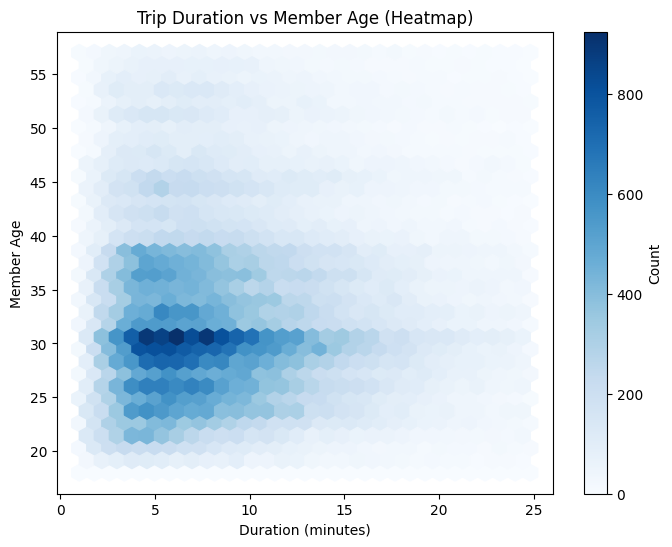

In [55]:
# Identify Q1 and Q3 for member_age
Q1_age = GoBike_cleaned['member_age'].quantile(0.25)
Q3_age = GoBike_cleaned['member_age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

# Define the outlier thresholds (1.5 * IQR rule) for member_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Filter the dataset to remove outliers for member_age
GoBike_cleaned = GoBike_cleaned[(GoBike_cleaned['member_age'] >= lower_bound_age) & (GoBike_cleaned['member_age'] <= upper_bound_age)]

plt.figure(figsize=(8, 6))
plt.hexbin(GoBike_cleaned['duration_min'], GoBike_cleaned['member_age'], gridsize=30, cmap='Blues')  # smaller grid size
plt.colorbar(label='Count')
plt.title('Trip Duration vs Member Age (Heatmap)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Member Age')
plt.show()


In [56]:
# Calculate trip count per age group
trip_count_per_age = GoBike_cleaned.groupby('member_age').size()

# Calculate mean duration per age group
mean_duration_per_age = GoBike_cleaned.groupby('member_age')['duration_min'].mean()

# Sort by trip_count in descending order and select top 5
top_5_trip_count = trip_count_per_age.sort_values(ascending=False).head(5)

# Get the corresponding mean duration for the top 5 ages
top_5_mean_duration = mean_duration_per_age[top_5_trip_count.index]

# Combine the trip count and mean duration into a DataFrame
top_5_stats = pd.DataFrame({
    'trip_count': top_5_trip_count,
    'mean_duration': top_5_mean_duration
})

# Display the top 5 ages with trip count and mean duration
print(top_5_stats)

# Get the highest and lowest age from the top 5
highest_age = top_5_stats.index.max()
lowest_age = top_5_stats.index.min()

# Display the highest and lowest age
print(f"Highest age in top 5: {highest_age}")
print(f"Lowest age in top 5: {lowest_age}")




            trip_count  mean_duration
member_age                           
31.0              9714       9.352814
26.0              8841       9.048139
30.0              8471       9.450270
29.0              8331       9.386522
28.0              8053       9.252438
Highest age in top 5: 31.0
Lowest age in top 5: 26.0


After reviewing the heatmap, it appears that the most common rider tend to be between the ages of 26 and 31, with trip durations around 9 minutes. This can be seen by the darker portions of the heatmap above. It's also important to note that we adjusted the member_age variable by removing outliers, which were likely caused by mistyped birth years in the rider profiles.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Based on the relationships observed above, we can see that higher trip durations are more common in the morning, among female riders, and with longer distances.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
Shown above we observed the mean distances traveled throughout the period of the day. The plot shows that the average rental is the longest in the morning. The renter travels on average 1.12 miles in the morning, 1 mile in the evening, 0.95 miles in the afternoon and 0.89 miles at night. This makes sense because the highest average duration is also in the morning. We can assume that this because people are trying to get to work early by going to work via bike rather than walking. 

## Multivariate Exploration

### Facet Boxplot - Duration by Gender for each User Type

**Lets answer the question: How does trip duration vary by gender across different user types?**

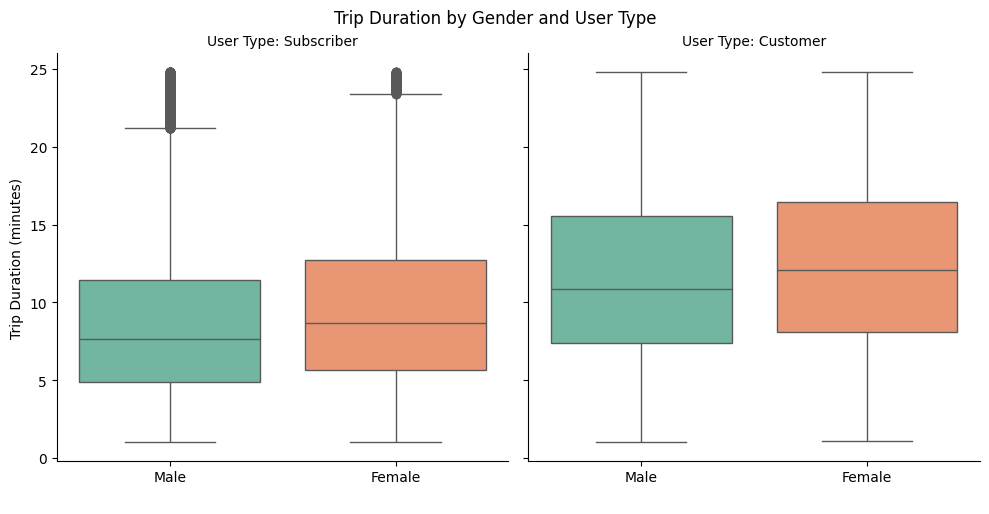

In [57]:
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Create a FacetGrid to facet by 'user_type' and plot boxplot of 'duration_min' by 'member_gender'
g = sns.FacetGrid(GoBike_cleaned, col="user_type", height=5)
g.map(sns.boxplot, "member_gender", "duration_min", order=['Male', 'Female'], palette='Set2')

# Add labels and title
g.set_axis_labels(' ', 'Trip Duration (minutes)')
g.set_titles("User Type: {col_name}")
plt.suptitle('Trip Duration by Gender and User Type', y=1.02)
plt.show()


The plot above shows that for both males and females, the average duration of rental bike is more for customers compared to subscribers. 

### Scatterplot of Distance vs Durations by Period of Day

**Lets answer the question: How does the relationship between trip duration and distance traveled vary by period of day**

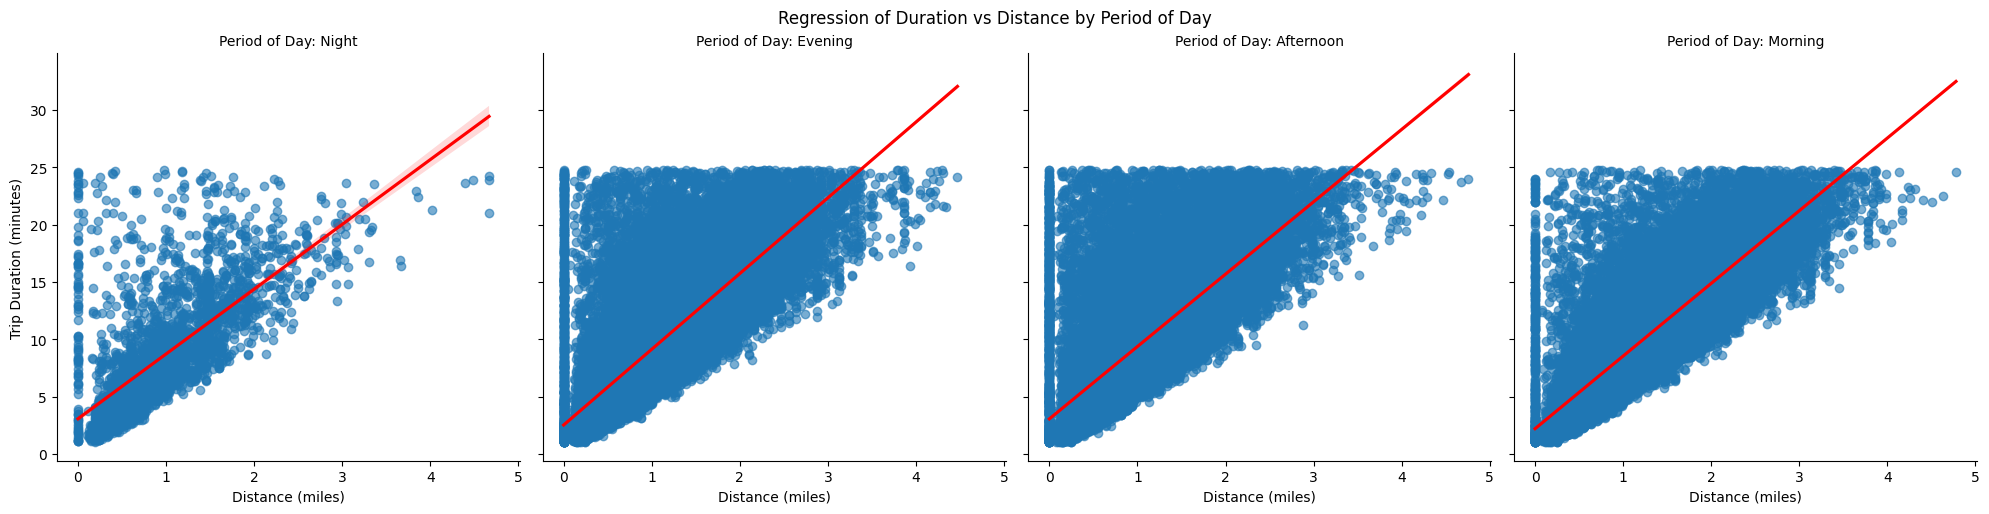

In [58]:
# Create a FacetGrid to facet by 'user_type' and plot scatterplot of 'duration_min' vs 'distance_miles'
g = sns.FacetGrid(GoBike_cleaned, col="period_of_day", height=5)
# Use regplot to add a regression line and scatter points, colored by 'user_type'
g.map(sns.regplot, "distance_miles", "duration_min", scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})

# Add labels and title
g.set_axis_labels('Distance (miles)', 'Trip Duration (minutes)')
g.set_titles("Period of Day: {col_name}")
plt.suptitle('Regression of Duration vs Distance by Period of Day', y=1.02)

# Show the plot
plt.show()


Upon analyzing the plot, we can observe that there aren't significant differences across the different periods of the day, except during the middle of the night. In general, there is a clear positive relationship between trip duration and distance throughout most of the day. However, there are still many data points above the regression line, which could be due to the way the distance variable is calculated, particularly since it is based on the distance between bike stations and doesn't account for round-trip journeys starting and ending at the same station.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

From the boxplot, we observed that the average trip duration for customers is generally higher than that of subscribers, both for males and females. This suggests that occasional users (customers) tend to take longer trips compared to regular users (subscribers). The scatterplot reinforces this by showing that there is a positive relationship between trip duration and distance, and this relationship holds fairly consistently across different periods of the day. This pattern suggests that users who travel longer distances tend to have longer trip durations, regardless of the time of day, which aligns with our expectation that longer trips take more time. Additionally, the fact that this positive relationship holds across all periods, except during the middle of the night, strengthens the idea that the duration-distance relationship is a consistent feature across various user groups.

### Were there any interesting or surprising interactions between features?

One interesting interaction observed is the higher average trip duration for customers compared to subscribers, both for males and females, as seen in the boxplot. This could suggest that customers, who are typically occasional users, tend to take longer trips. This is surprising because it might be assumed that subscribers, who pay a subscription fee for regular use, would take longer trips in order to maximize the value of their membership. However, it seems that the motivation to subscribe may be more about convenience and saving money for shorter, more frequent trips rather than longer excursions. This pattern challenges the assumption that subscribers would always take longer trips, and highlights how different user behaviors and motivations may drive trip duration.

## Conclusions

- Weekdays are significantly greater than weekends
- Customers tend to rent bikes for longer durations, regardless of gender, compared to subscribers.
- The morning period is the busiest for rentals, with the longest distances covered during that time.
- Overall, the most common rider was a person aged 26 to 31 riding for about 9 minutes
- While there are clear patterns between trip distance and duration, some data inconsistencies arise due to the method used to calculate trip durations.

After reviewing my data, I've realized that to tell a more compelling story, I need to shift my focus from duration as the main feature variable to instead analyzing the frequency of rentals. While duration was initially the response variable, the true goal is to optimize bike transactions. By examining the frequency of rentals, I can better identify and target the ideal audience for the bike-sharing system. This shift will allow me to explain who the best target audience is in the second part of this project.

### Final Data for Part II

In [59]:
#Create a final version with only variable need for explanatory
Final_Rentals = GoBike_cleaned.drop(columns=[
    'bike_share_for_all_trip', 'distance_miles', 'period_of_day'
])

Final_Rentals.head()

,duration_min,user_type,member_gender,rounded_time,day_of_week,member_age
6,19.116667,Subscriber,Female,00:00,Thursday,36.0
9,17.483333,Subscriber,Male,00:00,Thursday,27.0
10,7.633333,Subscriber,Female,00:00,Thursday,23.0
11,8.433333,Subscriber,Male,00:00,Thursday,26.0
12,19.600000,Customer,Male,00:00,Thursday,29.0


In [60]:
#Save to working director
Final_Rentals.to_csv('Final_Rentals.csv', index=False)